# Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt 
import math
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import joblib as jb

import warnings 
warnings.filterwarnings('ignore')

# Load data

In [2]:
data = pd.read_csv('HPG_stock_price.csv', parse_dates=['time'], index_col='time')

# Check and clean data

In [3]:
df = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4499 entries, 2007-11-15 to 2025-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4499 non-null   float64
 1   high    4499 non-null   float64
 2   low     4499 non-null   float64
 3   close   4499 non-null   float64
 4   volume  4499 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 210.9 KB


In [5]:
df.describe()

,open,high,low,close,volume
count,4499.000000,4499.000000,4499.000000,4499.000000,4.499000e+03
mean,8.951436,9.066479,8.838389,8.945719,9.380932e+06
std,8.908439,9.016483,8.795902,8.894058,1.484453e+07
min,0.570000,0.570000,0.570000,0.570000,0.000000e+00
25%,1.510000,1.520000,1.490000,1.510000,4.845200e+05
50%,4.970000,5.020000,4.920000,4.970000,2.794310e+06
75%,15.950000,16.180000,15.680000,15.930000,1.419564e+07
max,33.250000,33.480000,32.970000,33.250000,2.159991e+08


In [6]:
df.head()

,open,high,low,close,volume
time,,,,,
2007-11-15,2.05,2.05,1.72,2.00,1306330
2007-11-16,1.91,1.91,1.91,1.91,248510
2007-11-19,1.81,1.81,1.81,1.81,120480
2007-11-20,1.73,1.73,1.73,1.73,58710
2007-11-21,1.65,1.80,1.65,1.80,728080


In [7]:
df[df['volume'] == 0]

,open,high,low,close,volume
time,,,,,
2018-01-23,12.05,12.05,12.05,12.05,0
2018-01-24,12.05,12.05,12.05,12.05,0


In [8]:
def ffill_value(df):
    df.loc[df['volume'] == 0, :] = np.nan
    df = df.ffill()
    return df
df = ffill_value(df)

In [9]:
df.describe()

,open,high,low,close,volume
count,4499.000000,4499.000000,4499.000000,4499.000000,4.499000e+03
mean,8.951089,9.066497,8.838042,8.945719,9.383894e+06
std,8.908333,9.016489,8.795791,8.894058,1.484333e+07
min,0.570000,0.570000,0.570000,0.570000,5.000000e+01
25%,1.510000,1.520000,1.490000,1.510000,4.848900e+05
50%,4.970000,5.020000,4.920000,4.970000,2.801350e+06
75%,15.950000,16.180000,15.680000,15.930000,1.419564e+07
max,33.250000,33.480000,32.970000,33.250000,2.159991e+08


In [10]:
# Chuyển về Log Price và tính Daily Log Return (Target)
df['lp'] = np.log(df['close'])
df['ret_1d'] = df['lp'].diff(1)

# EDA

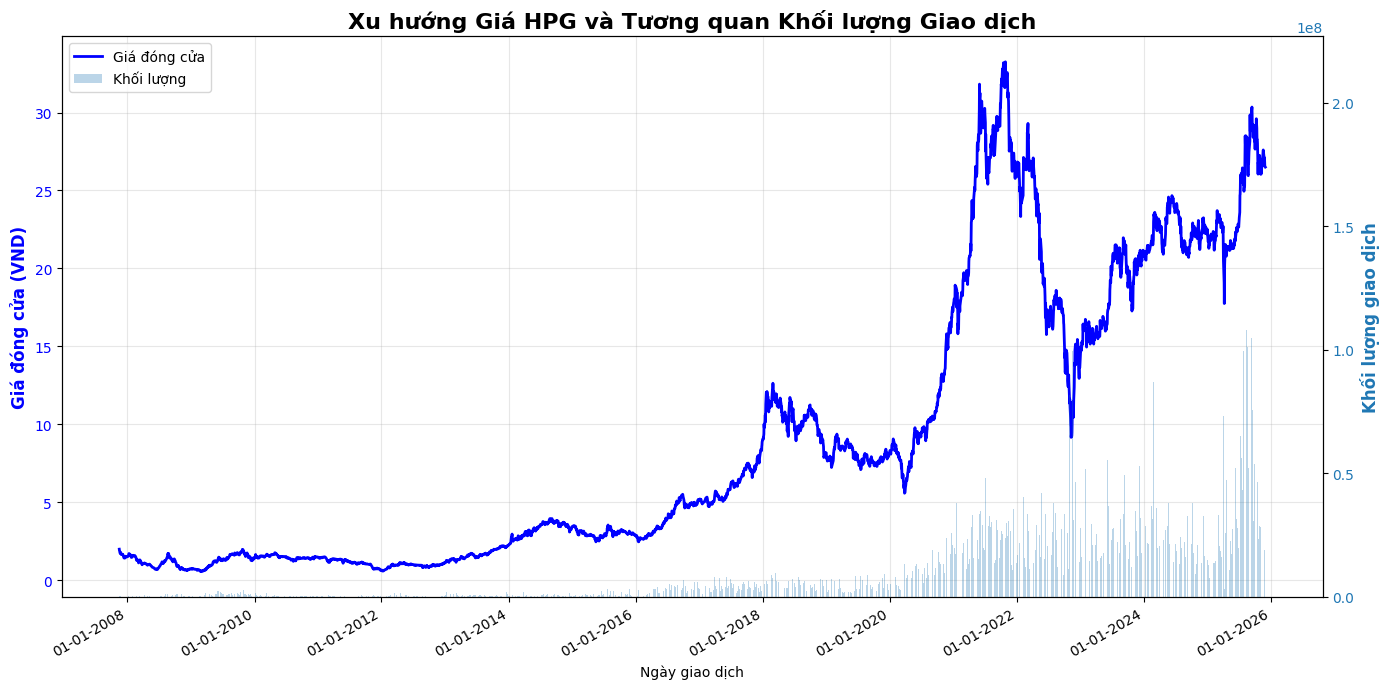

In [ ]:
# Khởi tạo biểu đồ
fig, ax1 = plt.subplots(figsize=(14, 7))

# VẼ GIÁ ĐÓNG CỬA (Trục trái)
color_price = 'blue'
ax1.set_xlabel('Ngày giao dịch')
ax1.set_ylabel('Giá đóng cửa (VND)', color=color_price, fontsize=12, fontweight='bold')
ax1.plot(df.index, df['close'], color=color_price, linewidth=2, label='Giá đóng cửa')
ax1.tick_params(axis='y', labelcolor=color_price)
ax1.grid(True, alpha=0.3)

# VẼ KHỐI LƯỢNG (Trục phải)
ax2 = ax1.twinx()  # Tạo trục thứ hai chia sẻ cùng trục X
color_vol = 'tab:blue'
ax2.set_ylabel('Khối lượng giao dịch', color=color_vol, fontsize=12, fontweight='bold')
ax2.bar(df.index, df['volume'], color=color_vol, alpha=0.3, label='Khối lượng')
ax2.tick_params(axis='y', labelcolor=color_vol)

# Tinh chỉnh hiển thị
plt.title('Xu hướng Giá HPG và Tương quan Khối lượng Giao dịch', fontsize=16, fontweight='bold')

# Định dạng ngày tháng trên trục X
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
fig.autofmt_xdate() # Tự động xoay ngày tháng để không bị đè lên nhau

# Thêm chú thích
lines, labels = ax1.get_legend_handles_labels()
bars, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + bars, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

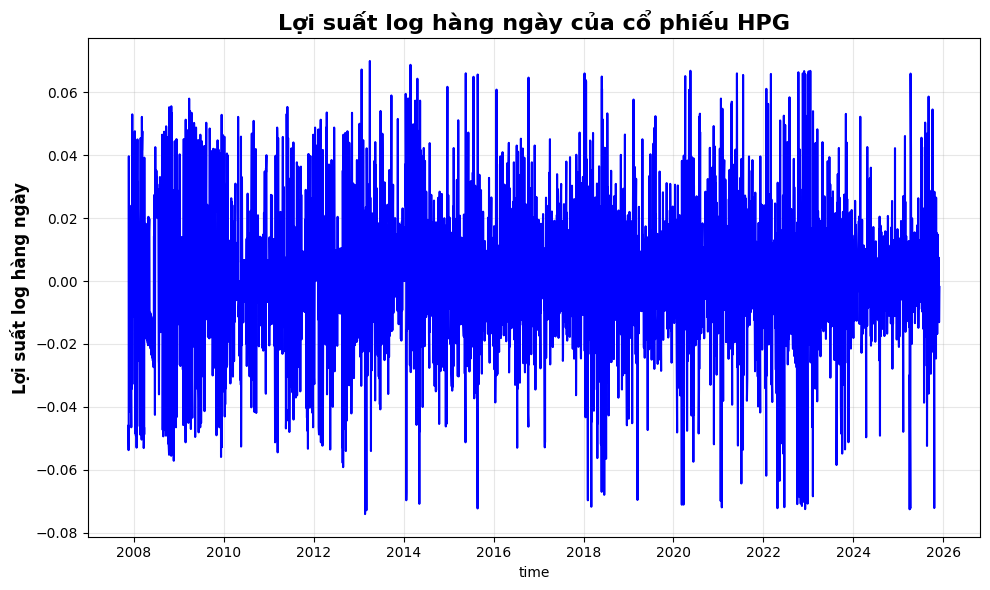

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='ret_1d', color='blue')
plt.ylabel('Lợi suất log hàng ngày', fontsize=12, fontweight='bold')
plt.title('Lợi suất log hàng ngày của cổ phiếu HPG', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

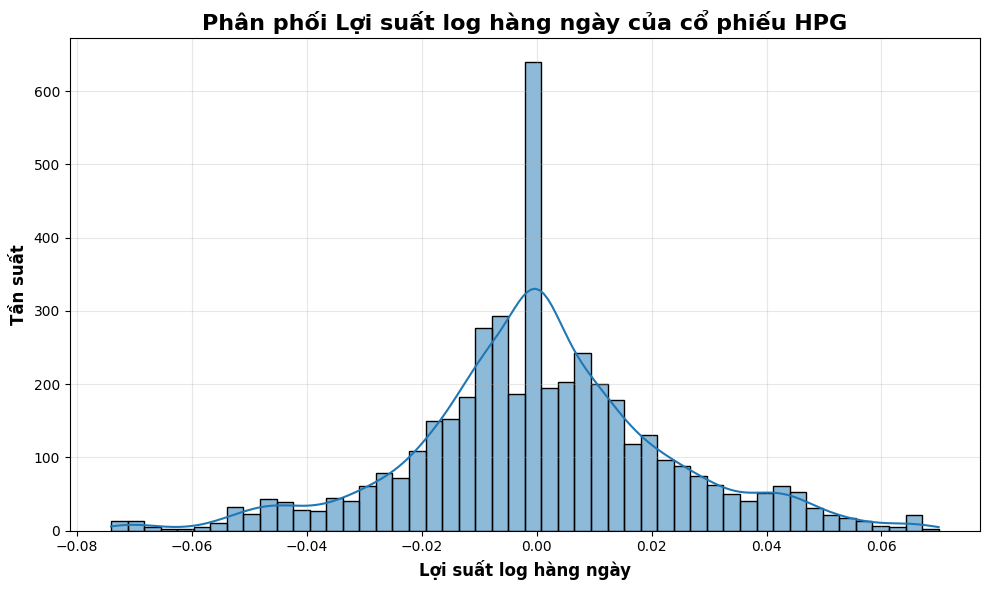

In [13]:

plt.figure(figsize=(10, 6))
sns.histplot(df['ret_1d'].dropna(), bins=50, kde=True)
plt.ylabel('Tần suất', fontsize=12, fontweight='bold')
plt.xlabel('Lợi suất log hàng ngày', fontsize=12, fontweight='bold')
plt.title('Phân phối Lợi suất log hàng ngày của cổ phiếu HPG', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()

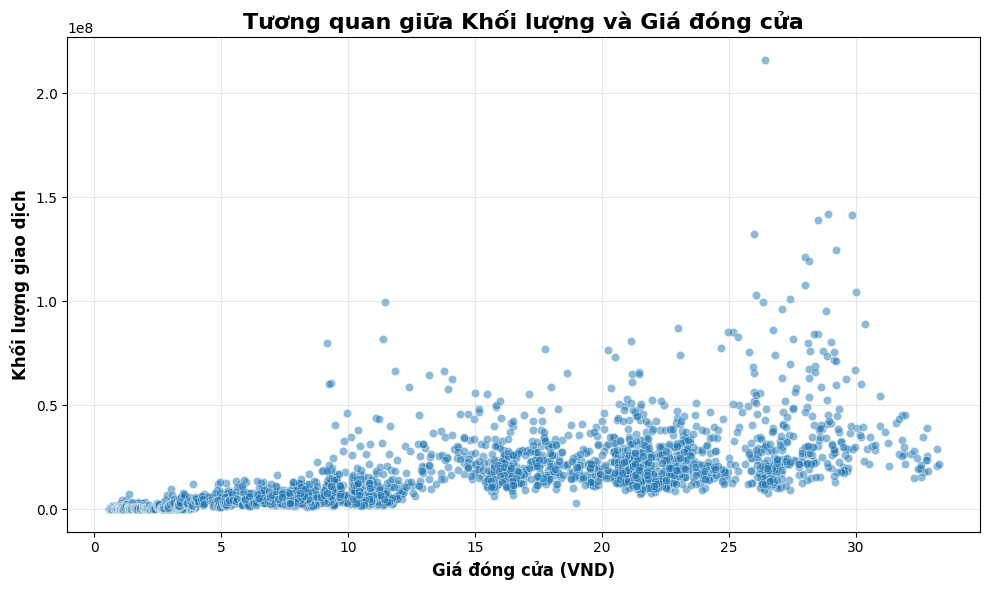

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='close', y='volume', data=df, alpha=0.5)
plt.title('Tương quan giữa Khối lượng và Giá đóng cửa', fontsize=16, fontweight='bold')
plt.ylabel('Khối lượng giao dịch', fontsize=12, fontweight='bold')
plt.xlabel('Giá đóng cửa (VND)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()

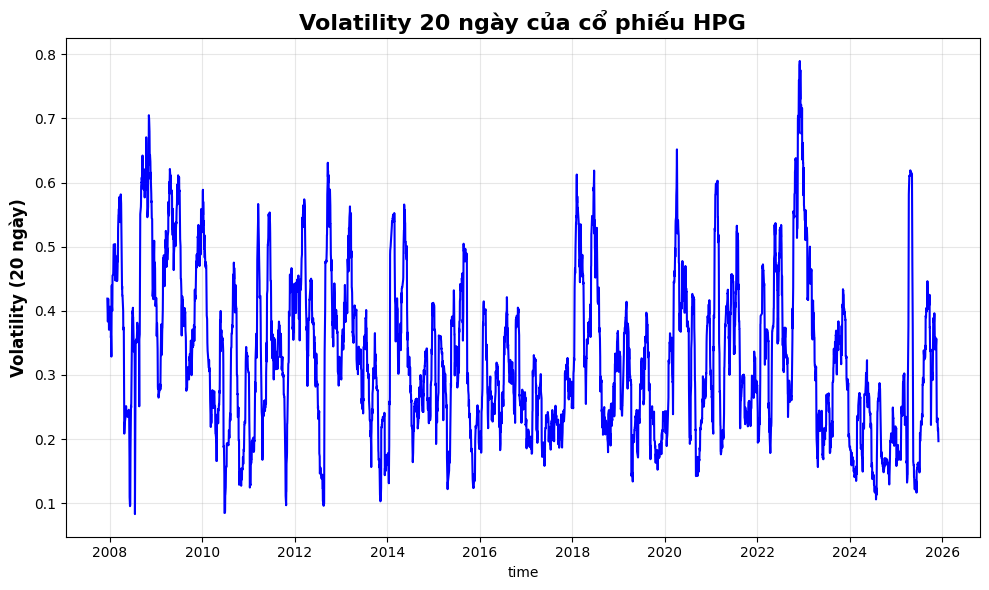

In [15]:
# rolling 20 dáy volatility 
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y=df['ret_1d'].rolling(window=20).std()*math.sqrt(252), color='blue')
plt.ylabel('Volatility (20 ngày)', fontsize=12, fontweight='bold')
plt.title('Volatility 20 ngày của cổ phiếu HPG', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

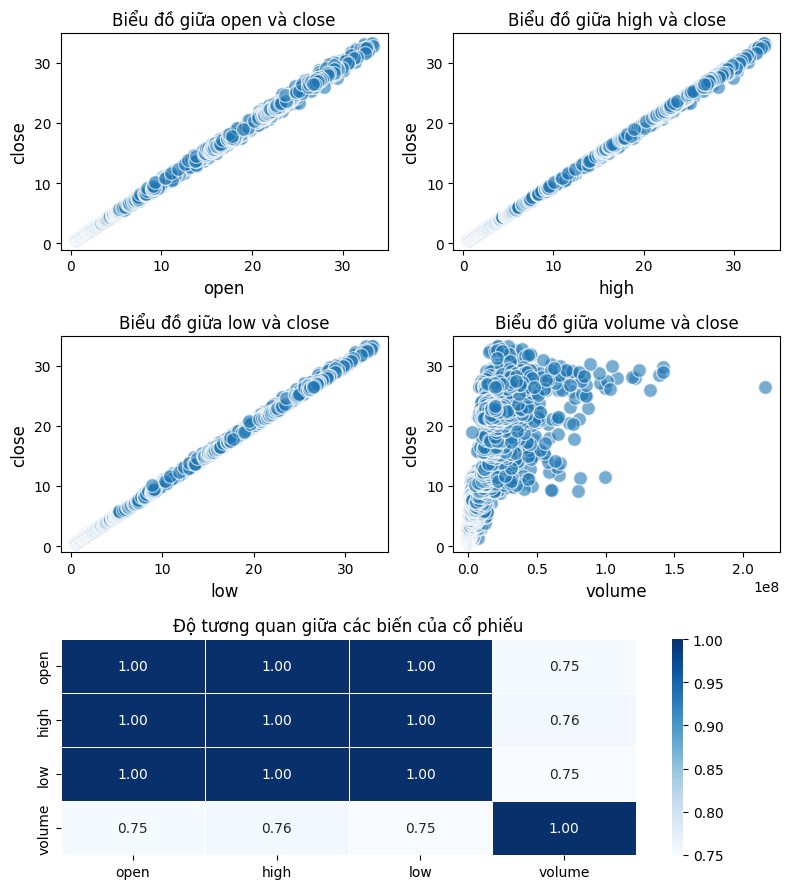

In [16]:
def relationship_plot(df):
    # print(f"Cổ phiếu {key}")
    X = ['open', 'high', 'low', 'volume']
    y = 'close'
    
    n_scatter = len(X)
    n_scatter_rows = math.ceil(n_scatter / 2)
    total_rows = n_scatter_rows + 1
    
    fig, axes = plt.subplots(total_rows, 2, figsize=(8, 3*total_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    
    for i, col in enumerate(X):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].scatter(df[col], df[y], alpha=0.6, edgecolors='w', s=100)
        axes[row, col_idx].set_title(f"Biểu đồ giữa {col} và {y}", fontsize=12)
        axes[row, col_idx].set_xlabel(col, fontsize=12)
        axes[row, col_idx].set_ylabel(y, fontsize=12)
    
    if n_scatter % 2 != 0:
        axes[n_scatter_rows - 1, 1].axis('off')
    
    for j in range(2):
        fig.delaxes(axes[-1, j])
    ax_heat = fig.add_subplot(total_rows, 1, total_rows)
    df_corr = df[X].corr()
    sns.heatmap(df_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, ax=ax_heat)
    ax_heat.set_title("Độ tương quan giữa các biến của cổ phiếu", fontsize=12)
    
    plt.tight_layout()
    plt.show()

relationship_plot(df)

# Data Preprocessing

In [ ]:
def create_features(data):
    data = data.copy()
    # Price movements
    # data['Daily_Return'] = data['close'].pct_change()
    
    # Moving averages
    data['MA_5'] = data['close'].rolling(window=5).mean()
    data['MA_10'] = data['close'].rolling(window=10).mean()
    data['MA_20'] = data['close'].rolling(window=20).mean()
    
    # Momentum
    data['Momentum_5'] = data['close'].diff(5)
    data['Momentum_10'] = data['close'].diff(10)
    
    # Volatility
    data['Volatility_5'] = data['close'].rolling(window=5).std()
    data['Volatility_10'] = data['close'].rolling(window=10).std()
    
    # RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = data['close'].ewm(span=12, adjust=False).mean()
    ema26 = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema12 - ema26
    
    return data.dropna()


# Create Sequences
def create_lagged_dataset(data, target='ret_1d'):
    X, y, dates, last_prices = [], [], [], []
    lags = [1, 2, 3, 5, 10, 20]
    max_lag = max(lags)
    
    features = ['volume', 'MA_5', 'MA_10', 'MA_20', 
                'Momentum_5', 'Momentum_10', 'Volatility_5', 'Volatility_10', 'RSI', 'MACD']
    
    valid_features = [f for f in features if f in data.columns]
    data_values = data[valid_features].values
    target_values = data[target].values
    close_prices = data['close'].values
    time_values = data.index.values
    
    for i in range(max_lag, len(data)):
        specific_lags = [data_values[i - lag] for lag in lags]
        X.append(np.array(specific_lags).flatten())
        y.append(target_values[i])
        dates.append(time_values[i])
        last_prices.append(close_prices[i-1])
        
    return np.array(X), np.array(y), np.array(dates), np.array(last_prices), valid_features

# Custom Time Series Split
def train_test_split_time_series(X, y, test_size=0.1, dates=None, last_prices=None):
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_test = dates[split_idx:]
    lp_test = last_prices[split_idx:]
    return X_train, X_test, y_train, y_test, dates_test, lp_test


In [21]:
df_features = create_features(df)
X, y, dates, last_prices, feature_names = create_lagged_dataset(df_features)

In [22]:
X_train, X_test, y_train, y_test, dates_test, lp_test = train_test_split_time_series(X, y, dates=dates, last_prices=last_prices)

In [ ]:
# Hàm tính các metrics cơ bản
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, mape, rmse, r2

# Hàm đánh giá đa thang đo
def evaluate_all_scales(y_val_ret, pred_val_ret, last_prices_val):
    # Metrics trên Log Return 
    mae_ret, mape_ret, rmse_ret, r2_ret = calculate_metrics(y_val_ret, pred_val_ret)
    
    # Chuyển đổi sang Giá thực tế
    y_val_price = last_prices_val * np.exp(y_val_ret)
    y_val_pred_price = last_prices_val * np.exp(pred_val_ret)
    
    # Metrics trên Giá
    mae_p = mean_absolute_error(y_val_price, y_val_pred_price)
    rmse_p = np.sqrt(mean_squared_error(y_val_price, y_val_pred_price))
    r2_p = r2_score(y_val_price, y_val_pred_price)
    
    return {
        'Return_R2': r2_ret,
        'Price_R2': r2_p,
        'Price_MAE': mae_p,
        'Price_RMSE': rmse_p,
        'y_actual_p': y_val_price,
        'y_pred_p': y_val_pred_price
    }

# Hàm vẽ biểu đồ 5 Folds
def plot_model_cv(model_name, model, X_train, y_train, dates, last_prices, df_original):
    tscv = TimeSeriesSplit(n_splits=5)
    fig, axes = plt.subplots(5, 1, figsize=(6, 8), sharex=True)
    fig.suptitle(f'Model: {model_name} - Evaluation on Price', fontsize=12, y=1.01)

    prices_all = df_original['close'].values
    dates_all = df_original.index.values
    
    fold_metrics = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
        # Split data
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        scaler = MinMaxScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)
        
        # Fit & Predict
        model.fit(X_tr_scaled, y_tr)
        val_preds_ret = model.predict(X_val_scaled)
        
        # Gọi hàm đánh giá đa thang đo
        res = evaluate_all_scales(y_val, val_preds_ret, last_prices[val_index])
        price_mae = res['Price_MAE'] * 1000  # Chuyển sang đơn vị VNĐ
        price_rmse = res['Price_RMSE'] * 1000
        fold_metrics.append({
            'Fold': f'Fold {fold+1}',
            'Price_MAE': price_mae,
            'Price_RMSE': price_rmse, 
            'Price_R2': res['Price_R2'],
            'Return_R2': res['Return_R2']
        })
        
        ax = axes[fold]
        # Vẽ Full History (Xám)
        ax.plot(dates_all, prices_all, color='lightgrey', alpha=0.4)
        
        # Vẽ Train (Xanh dương)
        # Chuyển đổi log return của tập train sang giá
        y_tr_price = last_prices[train_index] * np.exp(y_tr)
        ax.plot(dates[train_index], y_tr_price, color='blue', label='Train', linewidth=1)
        
        # Vẽ Actual (Xanh lá) và Prediction (Đỏ)
        ax.plot(dates[val_index], res['y_actual_p'], color='green', label='Actual', linewidth=1)
        ax.plot(dates[val_index], res['y_pred_p'], color='red', linestyle='--', label='Predict', linewidth=1)
        
        # Hiển thị cả Return R2 và Price MAE
        ax.set_title(f'Fold {fold+1} | R2: {res["Price_R2"]:.3f} | MAE: {price_mae:.2f} VNĐ')
        ax.legend(loc='upper left', ncol=2)
        ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()
    
    return fold_metrics



--- Đang xử lý mô hình: Linear Regression ---


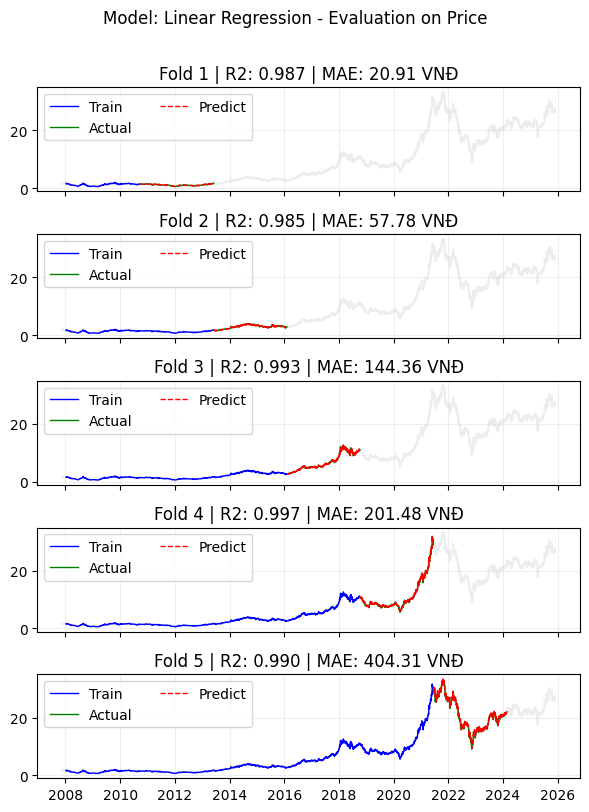

--- Đang xử lý mô hình: Random Forest ---


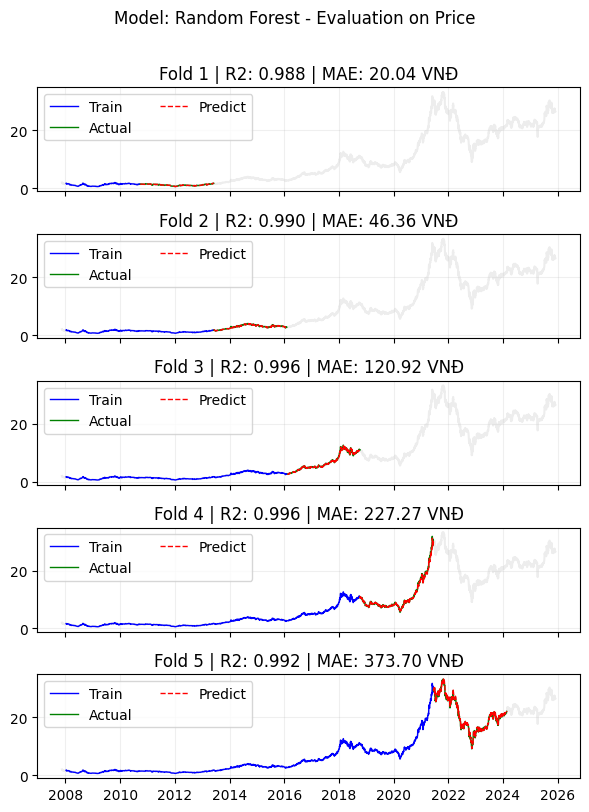

--- Đang xử lý mô hình: Gradient Boosting ---


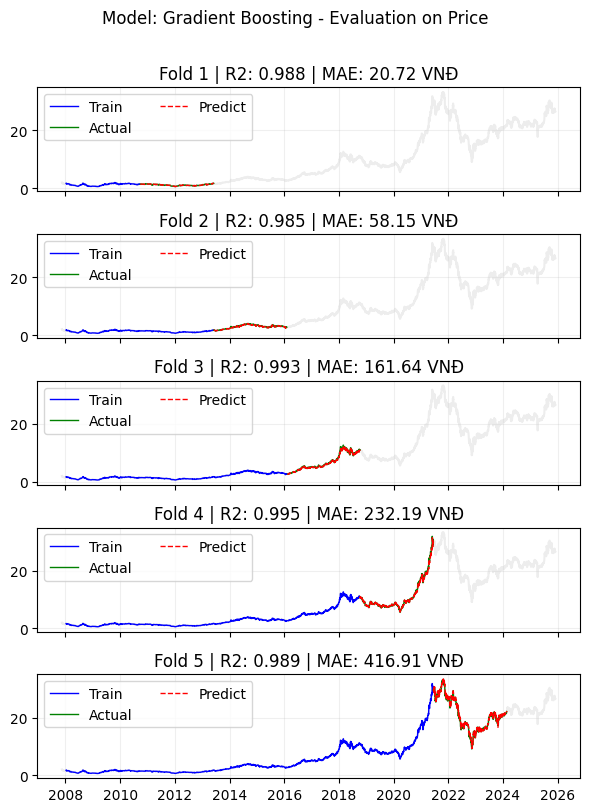

In [33]:
# Define Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor()
}
#  Chạy vòng lặp cho tất cả các Model 
results_summary = {}
for model_name, model in models.items():
    print(f"--- Đang xử lý mô hình: {model_name} ---")
    fold_metrics = plot_model_cv(model_name, model, X_train, y_train, dates, last_prices, df)
    results_summary[model_name] = fold_metrics 

In [46]:
def format_summary_table(df_input, model_name):
    # 1. Chuyển sang DataFrame và đảm bảo các cột số đúng kiểu dữ liệu
    df = pd.DataFrame(df_input)
    cols_to_format = ['Price_MAE', 'Price_RMSE', 'Price_R2']
    
    # 2. Tính toán Mean và Std
    means = df[cols_to_format].mean()
    stds = df[cols_to_format].std()
    
    # 3. Tạo dòng Average ± Std (Định dạng chuỗi)
    avg_std_row = {'Fold': 'AVG ± STD'}
    for col in cols_to_format:
        avg_std_row[col] = f"{means[col]:.2f} ± {stds[col]:.3f}"
    
    # 4. Để hiển thị đẹp, ta chuyển các dòng Fold cũ sang định dạng chuỗi tương ứng
    df_display = df.copy()
    for col in cols_to_format:
        df_display[col] = df_display[col].map(lambda x: f"{x:.2f}")
    
    # 5. Nối dòng tổng hợp vào bảng hiển thị
    df_final = pd.concat([df_display, pd.DataFrame([avg_std_row])], ignore_index=True)
    
    return df_final[['Fold'] + cols_to_format]

# Áp dụng cho từng mô hình
ln_results = format_summary_table(results_summary['Linear Regression'], "Linear Regression")
rf_results = format_summary_table(results_summary['Random Forest'], "Random Forest")
gb_results = format_summary_table(results_summary['Gradient Boosting'], "Gradient Boosting")

# Hiển thị kết quả
print("=== Linear Regression Results ===")
print(ln_results)
print("\n=== Random Forest Results ===")
print(rf_results)
print("\n=== Gradient Boosting Results ===")
print(gb_results)

=== Linear Regression Results ===
        Fold         Price_MAE        Price_RMSE      Price_R2
0     Fold 1             20.91             27.57          0.99
1     Fold 2             57.78             77.29          0.99
2     Fold 3            144.36            226.44          0.99
3     Fold 4            201.48            319.09          1.00
4     Fold 5            404.31            540.22          0.99
5  AVG ± STD  165.77 ± 151.065  238.12 ± 205.034  0.99 ± 0.005

=== Random Forest Results ===
        Fold         Price_MAE        Price_RMSE      Price_R2
0     Fold 1             20.04             26.75          0.99
1     Fold 2             46.36             63.77          0.99
2     Fold 3            120.92            184.70          1.00
3     Fold 4            227.27            365.92          1.00
4     Fold 5            373.70            503.19          0.99
5  AVG ± STD  157.66 ± 145.084  228.87 ± 202.543  0.99 ± 0.003

=== Gradient Boosting Results ===
        Fold      

Đã lưu Linear Regression
Đã lưu Random Forest
Đã lưu Gradient Boosting


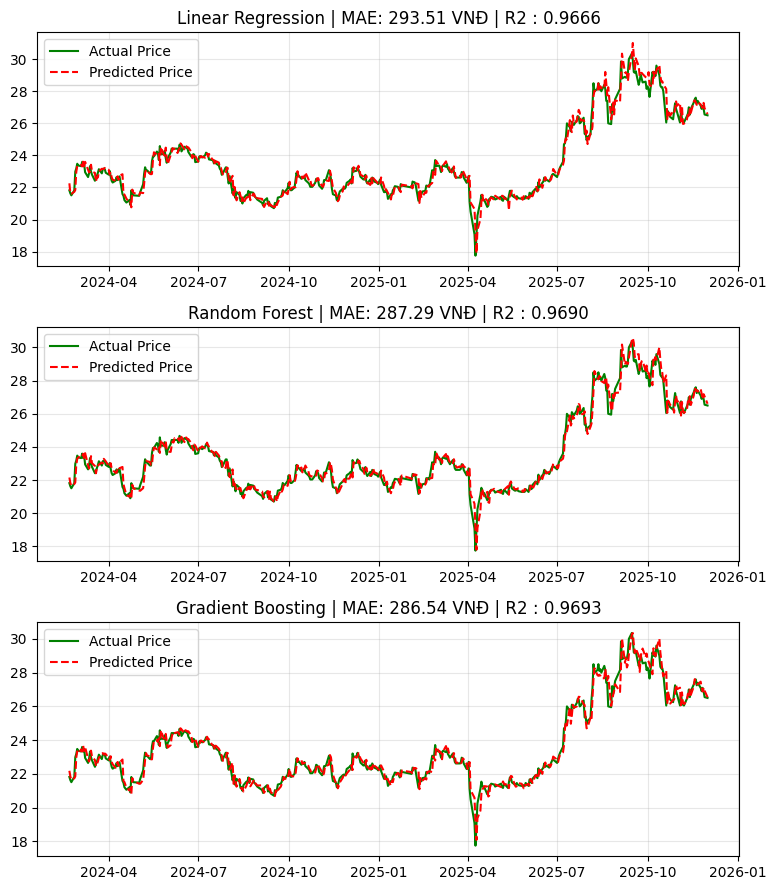


--- BẢNG SO SÁNH HIỆU SUẤT TRÊN TẬP TEST ---
               Model  Price_MAE (VNĐ)  Price_RMSE (VNĐ)  Price_R2
2  Gradient Boosting       286.540277        413.827632  0.969293
1      Random Forest       287.286217        415.858534  0.968991
0  Linear Regression       293.512996        431.757575  0.966574


In [ ]:
def evaluate_and_plot_test(models, X_train, y_train, X_test, y_test, dates_test, lp_test):
    test_results = []
   
    # Thiết lập vùng vẽ biểu đồ (mỗi model 1 hàng)
    fig, axes = plt.subplots(len(models), 1, figsize=(8, 3 * len(models)))
    if len(models) == 1: axes = [axes] # Đảm bảo axes luôn là list

    for i, (model_name, model) in enumerate(models.items()):
        
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Huấn luyện lại trên tập Train
        model.fit(X_train_scaled, y_train)
        
        
        # Dự báo trên tập Test
        test_preds_ret = model.predict(X_test_scaled)
        
        # Chuyển đổi sang thang đo Giá (Price)
        # lp_test là giá Close ngày t-1 của tập test
        y_test_price = lp_test * np.exp(y_test)
        y_test_pred_price = lp_test * np.exp(test_preds_ret)
        
        # Tính toán Metrics
        mae_ret, mape_ret, rmse_ret, r2_ret = calculate_metrics(y_test, test_preds_ret)
        mae_p = mean_absolute_error(y_test_price, y_test_pred_price) *1000  # Chuyển sang VNĐ
        rmse_p = np.sqrt(mean_squared_error(y_test_price, y_test_pred_price)) * 1000
        r2_p = r2_score(y_test_price, y_test_pred_price)
        
        # Lưu kết quả
        test_results.append({
            'Model': model_name,
            'Ret_R2': r2_ret,
            'Price_MAE (VNĐ)': mae_p,
            'Price_RMSE (VNĐ)': rmse_p,
            'Price_R2': r2_p
        })
        
        # 5. Vẽ biểu đồ so khớp thực tế vs dự báo
        ax = axes[i]
        ax.plot(dates_test, y_test_price, label='Actual Price', color='green', linewidth=1.5)
        ax.plot(dates_test, y_test_pred_price, label='Predicted Price', color='red', linestyle='--', linewidth=1.5)
        
        ax.set_title(f'{model_name} | MAE: {mae_p:.2f} VNĐ | R2 : {r2_p:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(test_results)

# Thực thi đánh giá
summary_df = evaluate_and_plot_test(models, X_train, y_train, X_test, y_test, dates_test, lp_test)

print("\n--- BẢNG SO SÁNH HIỆU SUẤT TRÊN TẬP TEST ---")
print(summary_df[['Model', 'Price_MAE (VNĐ)', 'Price_RMSE (VNĐ)', 'Price_R2']].sort_values(by='Price_MAE (VNĐ)'))

In [36]:
# Tạo danh sách chứa trung bình CV của 3 mô hình
cv_averages = []

# Lấy các giá trị từ các biến mean_values đã tính
for name, mean_vals in zip(['Linear Regression', 'Random Forest', 'Gradient Boosting'], 
                           [mean_values_ln, mean_values_rf, mean_values_gb]):
    cv_averages.append({
        'Model': name,
        'Train_MAE': mean_vals['Price_MAE'],
        'Train_RMSE': mean_vals['Price_RMSE'],
        'Train_R2': mean_vals['Price_R2']
    })

# Chuyển thành DataFrame
df_cv_summary = pd.DataFrame(cv_averages)

df_test_summary = pd.DataFrame(summary_df)

# Đổi tên cột để khi nối bảng không bị trùng lặp và dễ so sánh
df_test_summary = df_test_summary.rename(columns={
    'Price_MAE (VNĐ)': 'Test_MAE',
    'Price_RMSE (VNĐ)': 'Test_RMSE',
    'Price_R2': 'Test_R2',
    # 'Ret_R2': 'Test_Ret_R2'
})

# Nối hai bảng dựa trên tên Model
final_comparison = pd.merge(df_cv_summary, df_test_summary, on='Model')

# Sắp xếp các cột để so sánh MAE cạnh nhau, R2 cạnh nhau
final_comparison = final_comparison[[
    'Model', 
    'Train_MAE', 'Test_MAE', 
    'Train_R2', 'Test_R2', 
    # 'Test_Ret_R2'
]]

print("=== BẢNG SO SÁNH TỔNG HỢP: TRAIN VS TEST  ===")
final_comparison.sort_values(by='Test_MAE', inplace=True)
print(final_comparison)

=== BẢNG SO SÁNH TỔNG HỢP: TRAIN VS TEST  ===
               Model   Train_MAE    Test_MAE  Train_R2   Test_R2
2  Gradient Boosting  177.923883  286.540277  0.990068  0.969293
1      Random Forest  157.660351  287.286217  0.992165  0.968991
0  Linear Regression  165.767257  293.512996  0.990598  0.966574


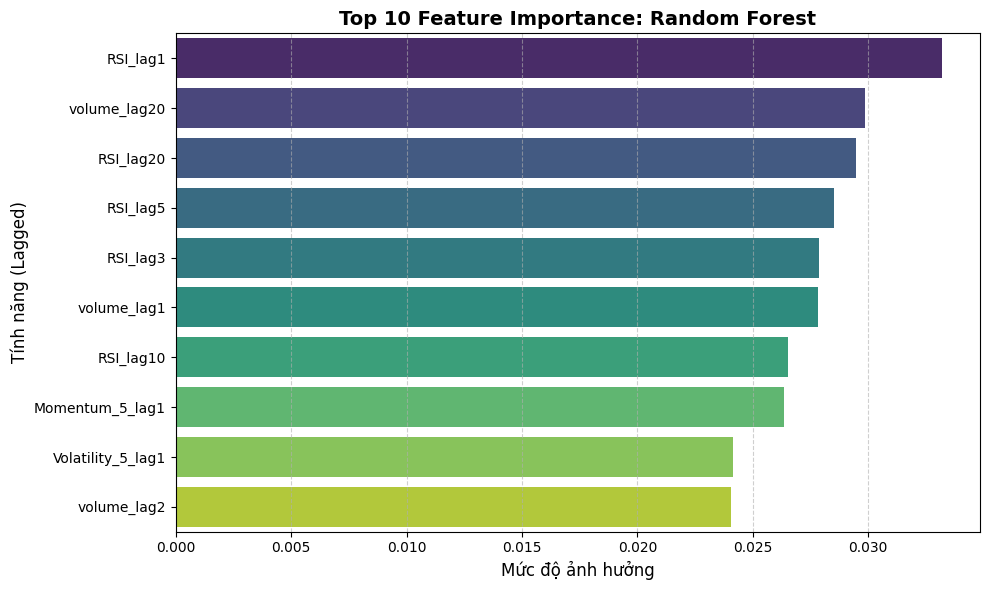

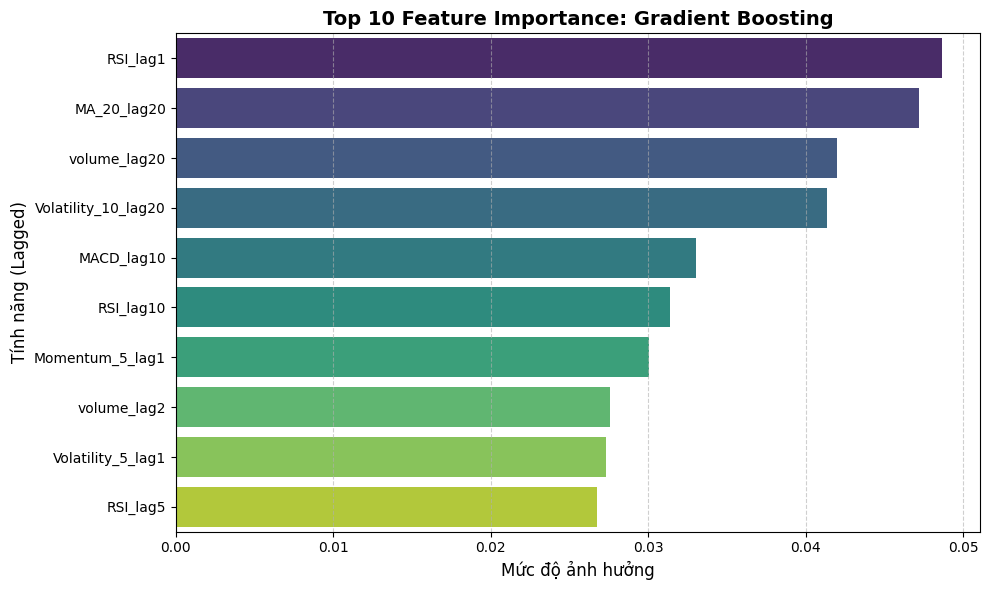

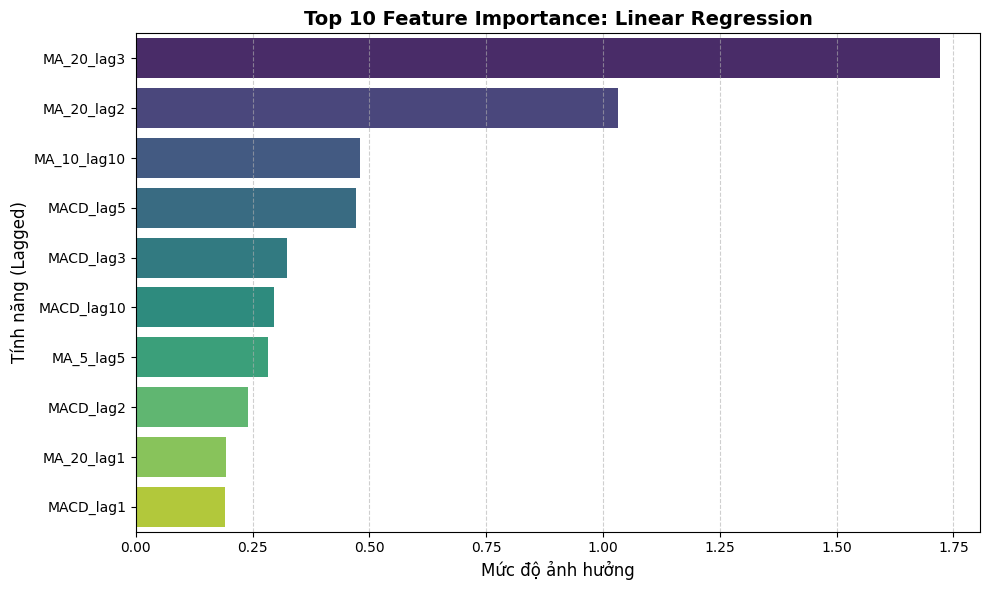

In [ ]:
def plot_feature_importance(model, model_name, feature_names):
    """
    Vẽ Top 10 Feature Importance cho một model cụ thể.
    """
    # Trích xuất độ quan trọng
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Linear Regression dùng coef_, ta lấy trị tuyệt đối và làm phẳng mảng
        importances = np.abs(model.coef_).flatten()
    else:
        print(f"Model {model_name} không hỗ trợ tính Feature Importance.")
        return

    # Kiểm tra độ dài để tránh lỗi ValueError
    if len(feature_names) != len(importances):
        print(f"Lỗi lệch độ dài ở {model_name}: Tên ({len(feature_names)}) vs Chỉ số ({len(importances)})")
        return

    # Tạo DataFrame và lấy Top 10
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    
    plt.title(f'Top 10 Feature Importance: {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Mức độ ảnh hưởng', fontsize=12)
    plt.ylabel('Đặc trưng', fontsize=12)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



# Tạo lagged feature names
lags = [1, 2, 3, 5, 10, 20]
extended_feature_names = []
# feature_names là danh sách 11 biến gốc
for lag in lags:
    for f_name in feature_names:
        extended_feature_names.append(f"{f_name}_lag{lag}")

# 2. Load các model vào Dictionary để quản lý tập trung
loaded_models = {
    "Random Forest": jb.load('random_forest_model_train.pkl'),
    "Gradient Boosting": jb.load('gradient_boosting_model_train.pkl'),
    "Linear Regression": jb.load('linear_regression_model_train.pkl')
}

# Vòng lặp vẽ biểu đồ cho từng model
for name, model in loaded_models.items():
    plot_feature_importance(model, name, extended_feature_names)

In [41]:

def train_and_save_final_models(models, X_train, y_train, X_test, y_test):
    """
    Hàm gộp tập Train + Test, huấn luyện lại và lưu model/scaler.
    """

    # 2. Gộp toàn bộ dataset (Train + Test)
    X_full = np.vstack((X_train, X_test))
    y_full = np.concatenate((y_train, y_test))

    # 3. Khởi tạo và Fit Scaler trên toàn bộ dữ liệu mới
    scaler = MinMaxScaler()
    X_full_scaled = scaler.fit_transform(X_full)
    
    # Lưu Scaler duy nhất dùng chung cho tất cả models
    jb.dump(scaler, 'scaler.pkl')
    print("Đã lưu scaler.pkl")

    # 4. Huấn luyện và lưu từng Model
    for model_name, model in models.items():
        # Fit trên dữ liệu đã scale toàn phần
        model.fit(X_full_scaled, y_full)
        
        # Làm sạch tên để đặt tên file
        clean_name = model_name.replace(" ", "_").lower()
        model_filename = f'{clean_name}_model.pkl'
        
        # Lưu trữ
        jb.dump(model, model_filename)
        print(f"Đã huấn luyện và lưu: {model_filename}")


train_and_save_final_models(models, X_train, y_train, X_test, y_test)

Đã lưu scaler.pkl
Đã huấn luyện và lưu: linear_regression_model.pkl
Đã huấn luyện và lưu: random_forest_model.pkl
Đã huấn luyện và lưu: gradient_boosting_model.pkl


In [44]:
def predict_next_day(model_name, df_processed, feature_names, lags):
    # Load Model và Scaler đã lưu
    clean_name = model_name.replace(" ", "_").lower()
    
    try:
        model = jb.load(f'{clean_name}_model.pkl')
        scaler = jb.load(f'scaler.pkl')
    except FileNotFoundError:
        print("Không tìm thấy file model hoặc scaler.")
        return None

    # Lấy dữ liệu tại thời điểm mới nhất (Hôm nay) để dự báo cho (Ngày mai)
    last_idx = len(df_processed) - 1
    data_values = df_processed[feature_names].values
    
    # Tạo vector X_next
    X_next = np.array([data_values[last_idx + 1 - lag] for lag in lags]).flatten().reshape(1, -1)
    
    # 3. Scale dữ liệu đầu vào
    X_next_scaled = scaler.transform(X_next)
    
    # 4. Dự báo Log Return
    pred_ret = model.predict(X_next_scaled)[0]
    
    # 5. Chuyển đổi Log Return sang Giá thực tế (VNĐ)
    last_close = df_processed.iloc[-1]['close']
    last_date = df_processed.index[-1]
    predicted_price = last_close * np.exp(pred_ret)
    
    # Tính mức thay đổi dự kiến (%)
    change_pct = (np.exp(pred_ret) - 1) * 100
    
    print(f"--- DỰ BÁO CHO PHIÊN TIẾP THEO (Model: {model_name}) ---")
    print(f"Ngày dữ liệu cuối cùng: {last_date.date()}")
    print(f"Giá đóng cửa gần nhất: {last_close*1000:,.2f} VNĐ")
    print(f"Giá dự báo ngày mai: {predicted_price*1000:,.2f} VNĐ ({change_pct:+.2f}%)")
    
    return predicted_price

for model_name in loaded_models.keys():
    next_price = predict_next_day(model_name, df_features, feature_names, lags=[1, 2, 3, 5, 10, 20])

--- DỰ BÁO CHO PHIÊN TIẾP THEO (Model: Random Forest) ---
Ngày dữ liệu cuối cùng: 2025-12-01
Giá đóng cửa gần nhất: 26,500.00 VNĐ
Giá dự báo ngày mai: 26,499.69 VNĐ (-0.00%)
--- DỰ BÁO CHO PHIÊN TIẾP THEO (Model: Gradient Boosting) ---
Ngày dữ liệu cuối cùng: 2025-12-01
Giá đóng cửa gần nhất: 26,500.00 VNĐ
Giá dự báo ngày mai: 26,552.71 VNĐ (+0.20%)
--- DỰ BÁO CHO PHIÊN TIẾP THEO (Model: Linear Regression) ---
Ngày dữ liệu cuối cùng: 2025-12-01
Giá đóng cửa gần nhất: 26,500.00 VNĐ
Giá dự báo ngày mai: 26,646.25 VNĐ (+0.55%)
